In [129]:
import cv2
import yaml
import tensorflow as tf
import numpy as np
from ultralytics.utils.ops import xyxy2xywh

# TFlite

In [234]:
class TFinference:
    """YOLOv8 object detection model class for handling inference and visualization."""

    def __init__(self, tf_model, input_image, confidence_thres, iou_thres,cocolabel_path,positive_list):
        """
        Initializes an instance of the YOLOv8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        
        self.tf_model = tf_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        self.cocolabel_path = cocolabel_path

        # Load the class names from the COCO dataset
        self.classes = self.yaml_load()['names']
        
        # Generate a color palette for the classes
        # self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))
        self.color_palette = [(0,255,255),(255,255,0),(0,0,255)]
        # np.random.uniform(0, 255, size=(len(self.classes), 3))
        
        self.positive_list = positive_list

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{self.classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                    cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def yaml_load(self):
        with open(self.cocolabel_path, 'r') as file:
            cfg = yaml.safe_load(file)
        return cfg
    
    def preprocess(self):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        # image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data

    
    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.
        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        # outputs = np.transpose(np.squeeze(output[0]))
        outputs = np.squeeze(output[0])
        # print(outputs.shape)
        # (6300, 85) 4+1+80
        # (8400, 84)

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []
    
        # Calculate the scaling factors for the bounding box coordinates
        x_factor = self.img_width #/ self.input_width
        y_factor = self.img_height #/ self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][5:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                # Add the class ID, score, and box coordinates to the respective lists
                # and filter indices before NMS
                if class_id in self.positive_list:
                    class_ids.append(class_id)
                    scores.append(max_score)
                    boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)
        self.predresult = []
        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            self.predresult.append((class_id,box,score))
            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def pred_result(self):
        return self.predresult
    
    def main(self):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        # session = ort.InferenceSession(self.onnx_model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        interpreter = tf.lite.Interpreter(model_path=self.tf_model)
        interpreter.allocate_tensors()
        # Get the model inputs
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        # print(output_details)

        # Store the shape of the input for later use
        input_shape = input_details[0]['shape']

        self.input_width = input_shape[1]
        self.input_height = input_shape[2]

        # Preprocess the image data
        img_data = self.preprocess()
        
        # Run inference using the preprocessed image data
        interpreter.set_tensor(input_details[0]['index'], img_data )
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # print(output_data)
        # Perform post-processing on the outputs to obtain output image.
        return self.postprocess(self.img,output_data )  # output image



In [15]:
confidence_thres = 0.8
iou_thres = 0.1
label_path = "coco128.yaml"
positive_list = [0,2]

In [16]:
tflite_path = r"yolov5.tflite"
tfmodel = TFinference(
    tf_model = tflite_path, 
    input_image = "test_imgs/06.png", 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [17]:
result = tfmodel.main()

In [18]:
len(tfmodel.pred_result())

27

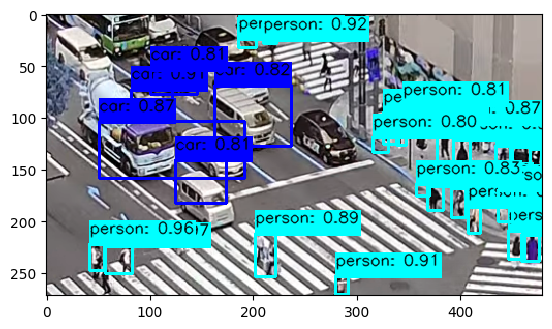

In [19]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()

In [20]:
tfmodel2 = TFinference(
    tf_model = tflite_path, 
    input_image = "test_imgs/09.png", 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [21]:
result = tfmodel2.main()

In [22]:
len(tfmodel2.pred_result())

14

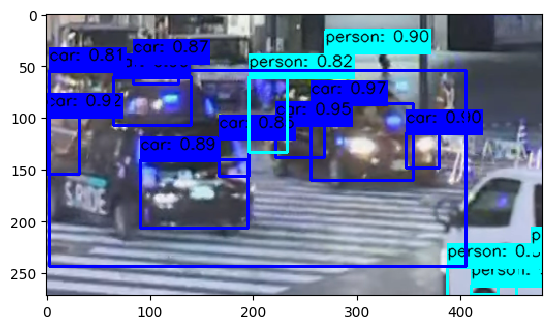

In [23]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()

In [248]:
class TFinference:
    """YOLOv8 object detection model class for handling inference and visualization."""

    def __init__(self, tf_model, input_image, confidence_thres, iou_thres,cocolabel_path,positive_list):
        """
        Initializes an instance of the YOLOv8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        
        self.tf_model = tf_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        self.cocolabel_path = cocolabel_path

        # Load the class names from the COCO dataset
        self.classes = self.yaml_load()['names']
        
        # Generate a color palette for the classes
        # self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))
        self.color_palette = [(0,255,255),(255,255,0),(0,0,255)]
        # np.random.uniform(0, 255, size=(len(self.classes), 3))
        
        self.positive_list = positive_list

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{self.classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                    cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def yaml_load(self):
        with open(self.cocolabel_path, 'r') as file:
            cfg = yaml.safe_load(file)
        return cfg
    
    def preprocess(self):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        # image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data

    
    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.
        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        # outputs = np.transpose(np.squeeze(output[0]))
        outputs = np.squeeze(output[0])
        # print(outputs.shape)
        # (6300, 85) 4+1+80
        # (8400, 84)

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []
    
        # Calculate the scaling factors for the bounding box coordinates
        x_factor = 1#self.img_width #/ self.input_width
        y_factor = 1 #self.img_height #/ self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][5:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                # left = int((x - w / 2) * x_factor)
                # top = int((y - h / 2) * y_factor)
                # width = int(w * x_factor)
                # height = int(h * y_factor)
                left = int(x)
                top = int(y)
                width = int(w )
                height = int(h )
                # Add the class ID, score, and box coordinates to the respective lists
                # and filter indices before NMS
                if class_id in self.positive_list:
                    class_ids.append(class_id)
                    scores.append(max_score)
                    boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)
        self.predresult = []
        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            self.predresult.append((class_id,box,score))
            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def pred_result(self):
        return self.predresult
    
    def main(self):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        # session = ort.InferenceSession(self.onnx_model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        interpreter = tf.lite.Interpreter(model_path=self.tf_model)
        interpreter.allocate_tensors()
        # Get the model inputs
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        # print(output_details)

        # Store the shape of the input for later use
        input_shape = input_details[0]['shape']

        self.input_width = input_shape[1]
        self.input_height = input_shape[2]

        # Preprocess the image data
        img_data = self.preprocess()
        
        # Run inference using the preprocessed image data
        interpreter.set_tensor(input_details[0]['index'], img_data )
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # print(output_data)
        # Perform post-processing on the outputs to obtain output image.
        return self.postprocess(self.img,output_data )  # output image



In [270]:
confidence_thres = 0.6
iou_thres = 0.2

In [271]:
tflite_path = "yolov5model_float16_quant.tflite"
tfmodel2 = TFinference(
    tf_model = tflite_path, 
    input_image = "test_imgs/09.png", 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [272]:
result = tfmodel2.main()


In [273]:
len(tfmodel2.pred_result())

13

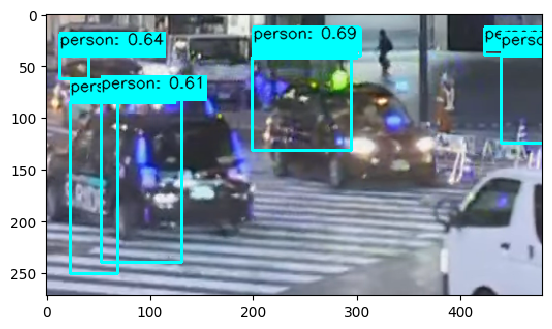

In [274]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()

# TFLite quantization

In [216]:
class TFinference:
    """YOLOv8 object detection model class for handling inference and visualization."""

    def __init__(self, tf_model, input_image, confidence_thres, iou_thres,cocolabel_path,positive_list):
        """
        Initializes an instance of the YOLOv8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        
        self.tf_model = tf_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        self.cocolabel_path = cocolabel_path

        # Load the class names from the COCO dataset
        self.classes = self.yaml_load()['names']
        
        # Generate a color palette for the classes
        # self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))
        self.color_palette = [(0,255,255),(255,255,0),(0,0,255)]
        # np.random.uniform(0, 255, size=(len(self.classes), 3))
        
        self.positive_list = positive_list

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{self.classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                    cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def yaml_load(self):
        with open(self.cocolabel_path, 'r') as file:
            cfg = yaml.safe_load(file)
        return cfg
    
    def preprocess(self):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) #/ 255.0
        # print(image_data.shape)
        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first
        # print(image_data.shape)
        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data

    
    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.
        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        # outputs = np.transpose(np.squeeze(output[0]))
        outputs = np.squeeze(output[0])
        # print(outputs.shape)
        # (6300, 85) 4+1+80
        # (8400, 84)

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []
    
        # Calculate the scaling factors for the bounding box coordinates
        x_factor = self.img_width #/ self.input_width
        y_factor = self.img_height #/ self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][5:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = xyxy2xywh(outputs[i][:4])
                # outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                # Add the class ID, score, and box coordinates to the respective lists
                # and filter indices before NMS
                if class_id in self.positive_list:
                    class_ids.append(class_id)
                    scores.append(max_score)
                    boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)
        self.predresult = []
        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            self.predresult.append((class_id,box,score))
            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def pred_result(self):
        return self.predresult
    
    def main(self):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        # session = ort.InferenceSession(self.onnx_model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        interpreter = tf.lite.Interpreter(model_path=self.tf_model)
        interpreter.allocate_tensors()
        # Get the model inputs
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        # print(output_details)

        # Store the shape of the input for later use
        input_shape = input_details[0]['shape']

        self.input_width = input_shape[2]
        self.input_height = input_shape[3]

        
        # Preprocess the image data
        img_data = self.preprocess()
        self.img_data = img_data
        
        # Run inference using the preprocessed image data
        interpreter.set_tensor(input_details[0]['index'], img_data )
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # print(output_data)
        # Perform post-processing on the outputs to obtain output image.
        return self.postprocess(self.img,output_data )  # output image



In [217]:
confidence_thres = 0.4
iou_thres = 0.08

In [218]:
tflite_path = r"yolox_nano_int8_quantize.tflite"
Xtfmodel = TFinference(
    tf_model = tflite_path, 
    input_image = "test_imgs/05.png", 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [219]:
result = Xtfmodel.main()

In [220]:
Xtfmodel.pred_result()

[(0, [0, 197, 328, 73], 0.703125),
 (0, [165, 270, 196, 0], 0.64453125),
 (2, [461, 41, 16, 229], 0.546875),
 (0, [247, 252, 230, 18], 0.5),
 (0, [288, 0, 189, 270], 0.5),
 (0, [37, 129, 185, 59], 0.484375),
 (0, [375, 270, -33, -53], 0.47265625),
 (0, [348, 158, 20, 112], 0.4375),
 (0, [221, 119, 116, 71], 0.4296875),
 (0, [262, 114, 9, 156], 0.40234375)]

In [221]:
len(Xtfmodel.pred_result())

10

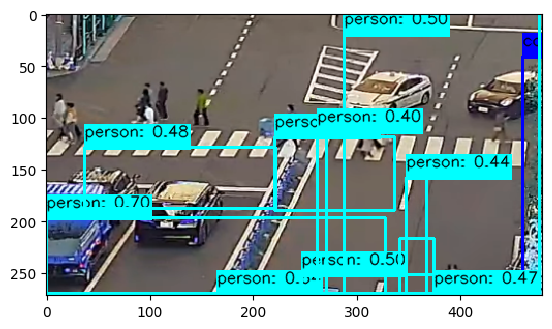

In [222]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()

In [230]:
confidence_thres = 0.6
iou_thres = 0.8

In [231]:
tflite_path = r"yolox_nano_dynamic_range_quantize.tflite"
Xtfmodel = TFinference(
    tf_model = tflite_path, 
    input_image = "test_imgs/05.png", 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [232]:
result = Xtfmodel.main()

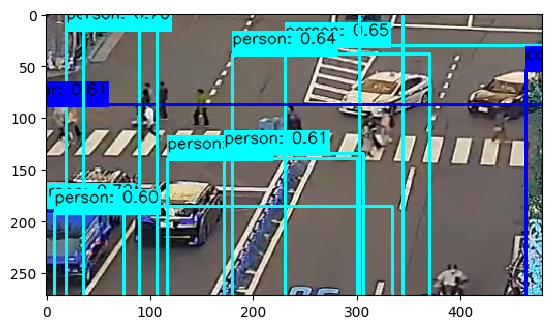

In [233]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()